# HW3: Multi-class Classification and Neural Networks

In this exercise, we will implement a one-vs-all logistic regression and neural networks to recognize hand-written digits.    

#### Notebook setup

In [1]:
import itertools as it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.misc
import scipy.optimize as op
import scipy.io
import random
from IPython.display import display, Math, Latex
import os
os.chdir('%s/courses/coursera_ml008/hw3' % os.getenv('DST'))
print(os.getcwd())

# plotting options
%matplotlib inline
np.set_printoptions(precision=4, linewidth=120)
plt.rc('font'  , size=18)
plt.rc('figure', figsize=(10, 8))
plt.rc('axes'  , labelsize=22)
plt.rc('legend', fontsize=16)

np.set_printoptions(precision=4)
plt.rc('figure', figsize=(10, 8))

/Users/rwk7t/Development/dst/courses/coursera_ml008/hw3


#### tex setup
$ \newcommand{\prob}{\mathbb{P}} $

## Multi-class Classification

For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9).  In this part of the exercise, you will extend logistic regression and apply it to one-vs-all classification. 

There are 5000 Training examples in the file, where each training example is a 20x20 pixel of grayscale intensity at that location.  The 20x20 grid is "unrolled" into a 400 dimensional vector.  Each of the training examples becomes a single row in our data matrix ${\bf X}$.  This gives us a 5000 by 400 matrix.

\begin{align}
{\bf X} = 
\left( 
\begin{array}{c}
-\ {{\bf x}^{(1)} }^T - \\
-\ {{\bf x}^{(2)} }^T - \\
\vdots  \\
-\ {{\bf x}^{(m)} }^T - \\
\end{array} 
\right)
\end{align}

The second part of the training set is a 5000-dimensional vector ${\bf y}$ that contains labels for the training set.  To make things easier in Octave/Matlab, the "0" digit is represented by "10".  Let us remap this since we are using python.

#### load the data

In [2]:
data = scipy.io.loadmat('ex3data1.mat')
data

{'X': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 '__globals__': [],
 '__header__': 'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ..., 
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
X_orig = data['X']
y_true = data['y']
y_true = np.where(y_true==10, 0, y_true)

In [4]:
# m is # training set, n is the number of features (pixels)
m, n = X_orig.shape
m, n

(5000, 400)

In [5]:
X      = np.concatenate((np.ones((m,1)), X_orig), axis=1)
X.shape, y_true.shape

((5000, 401), (5000, 1))

### visualize the data

In [6]:
image = np.zeros((10*20, 10*20))
random.seed(1)
for i in np.arange(100):
    row       = i/10
    col       = i%10
    row_begin = row*20
    row_end   = (row+1)*20
    col_begin = col*20
    col_end   = (col+1)*20
    idx       = random.uniform(0,m)
    image[row_begin:row_end,:][:,col_begin:col_end] = X_orig[idx].reshape(20,20)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


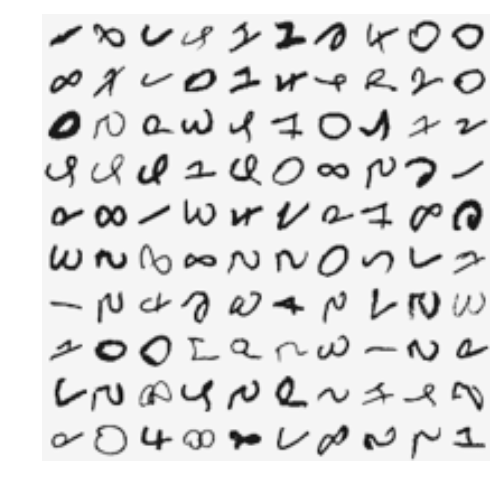

In [7]:
plt.imshow(image, cmap='Greys')
plt.axis('off')
plt.show()

### Vectorize Logistic Regressions

We will be using a mutiple one-vs-all logistic regression model to build a multi-class classifer.  Since there are 10 classes, we need to train 10 separate logistic regression classifiers. To make this training efficient, it is important to ensure that your code is well vectorized.  In this section, you will implement a vectorized version of logistic regression that does not emply any **for** loops.

#### vectorized cost function

First write a vectorized version of the cost function.  Recall that the unregularized logistic regression has a cost function of

\begin{align}
    J(\theta) &= \frac{1}{m} \sum_{i=1}^{m} \left[-y^{(i)}\log\left\{h_{\theta}(x^{(i)})\right\} - (1 - y^{(i)})\log\left\{1 - h_{\theta}(x^{(i)})\right\} \right]
\end{align}

To compute each element in the summation, we have to compute $h_{\theta}(x^{(i)})$ for every sample $i$, where $h_{\theta}(x^{(i)}) = g({\bf \theta}^T x^{(i)})$ and $g(z) = \frac{1}{1 + e^{-z}}$ is the sigmoid function.  It turns out that we can compute this quickly for all our examples by using matrix multiplication where a row represent a element in the training set and a column represents a feature.  As before, define

\begin{align}
{\bf X} = 
\left( 
\begin{array}{c}
-\ {{\bf x}^{(1)} }^T - \\
-\ {{\bf x}^{(2)} }^T - \\
\vdots  \\
-\ {{\bf x}^{(m)} }^T - \\
\end{array} 
\right)
\end{align}

and 

\begin{align}
{\bf \theta} = 
\left( 
\begin{array}{ccc}
\theta_0 & \dots & \theta_n \\
\end{array} 
\right) \\
\end{align}

Thus, we can compute the product:


\begin{align}
\left( 
\begin{array}{ccc}
x_0^{(1)} & \dots  & x_n^{(1)} \\
x_0^{(2)} & \dots  & x_n^{(2)} \\
          & \vdots &           \\
x_0^{(m)} & \dots  & x_n^{(m)} \\
\end{array}
\right)
\left( 
\begin{array}{ccc}
\theta_0 & \dots & \theta_n \\
\end{array} 
\right)^T
&= \left( 
\begin{array}{ccc}
x_0^{(1)} & \dots  & x_n^{(1)} \\
x_0^{(2)} & \dots  & x_n^{(2)} \\
          & \vdots &           \\
x_0^{(m)} & \dots  & x_n^{(m)} \\
\end{array}
\right)
\left( 
\begin{array}{c}
\theta_0\\
\theta_1\\
\vdots \\
\theta_n\\
\end{array}
\right)
&= {\bf X}\ {\bf \theta}^T
\end{align}

#### logistic function

In [8]:
def g(z):
    return 1.0/(1 + np.exp(-z))

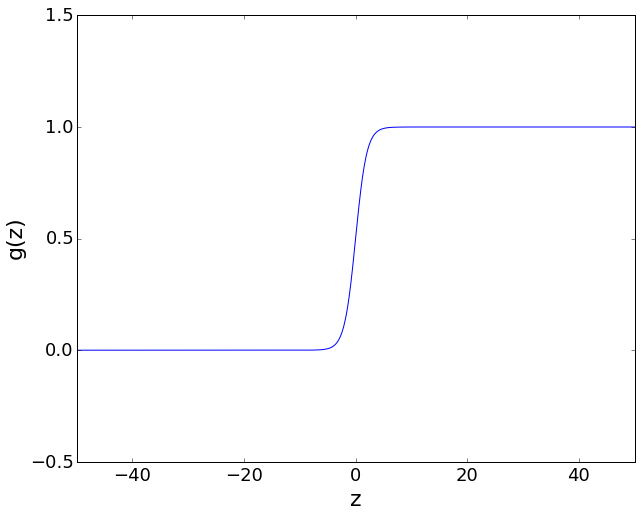

In [9]:
z = np.linspace(-50,50, 1000)
plt.plot(z, g(z))
plt.axis([-50, 50, -0.5, 1.5])
plt.xlabel("z")
plt.ylabel("g(z)")

#### hypothesis function

In [10]:
def h(theta, X):
    X     = np.asmatrix(X)
    theta = np.asmatrix(theta)
    return g(X*theta.T)

#### vectorized gradient

Recall that the gradient of the unregularized regression cost is a vector where the $j^{th}$ elemtn is defined as:

\begin{align}
    \frac{\partial J}{\partial \theta_f} 
    &= \frac{1}{m} \sum_{i=1}^{m} \left( h_{\theta}({\bf x}^{(i)}) - y^{(i)} \right) x_{f}^{(i)} \\
\end{align}

To vectorize this operation over the dataset, we start by writing out all partial derivatives:

\begin{align}
\left[ 
\begin{array}{c}
    \frac{\partial J}{\partial \theta_0} \\ 
    \frac{\partial J}{\partial \theta_1} \\ 
    \frac{\partial J}{\partial \theta_2} \\ 
    \vdots                               \\ 
    \frac{\partial J}{\partial \theta_n} \\ 
\end{array}
\right]
&= \frac{1}{m}
\left[
\begin{array}{c}
     \sum_{i=1}^{m} \left( h_{\theta}({\bf x}^{(i)}) - y^{(i)} \right) x_{0}^{(i)} \\
     \sum_{i=1}^{m} \left( h_{\theta}({\bf x}^{(i)}) - y^{(i)} \right) x_{1}^{(i)} \\
     \sum_{i=1}^{m} \left( h_{\theta}({\bf x}^{(i)}) - y^{(i)} \right) x_{2}^{(i)} \\
     \vdots \\
     \sum_{i=1}^{m} \left( h_{\theta}({\bf x}^{(i)}) - y^{(i)} \right) x_{n}^{(i)} \\
\end{array}
\right] \\
&= \frac{1}{m}\sum_{i=1}^{m} \left( h_{\theta}({\bf x}^{(i)}) - y^{(i)} \right) {\bf x^{(i)}} \\
&= \frac{1}{m} {\bf X}^T\left( h_{\theta}(x) - y \right) \\
\end{align}

where

\begin{align}
\left( h_{\theta}(x) - y \right) =
\left[
\begin{array}{c}
     h_{\theta}({\bf x}^{(1)}) - y^{(1)} \\
     h_{\theta}({\bf x}^{(2)}) - y^{(2)} \\
     h_{\theta}({\bf x}^{(3)}) - y^{(3)} \\
     \vdots \\
     h_{\theta}({\bf x}^{(m)}) - y^{(m)} \\
\end{array}
\right]
\end{align}

Note that ${\bf x}^{(i)}$ is a vector in feature space, while $\left(h_{\theta}({\bf x}^{(i)}) - y^{(i)}\right)$ is a scalar. To understand the last step of the derivation, let $\beta_i = \left(h_{\theta}({\bf x}^{(i)}) - y^{(i)}\right)$ and observe that:

\begin{align}
\sum_i \beta_i {\bf x}^{(i)} = 
\left[
\begin{array}{ccc}
| & | & & | \\
{\bf x}^{(1)} & {\bf x}^{(2)} & \dots &  {\bf x}^{(m)} \\
| & | & & | \\
\end{array}
\right]
\left[
\begin{array}{c}
\beta_1 \\
\beta_2 \\
\vdots  \\
\beta_m \\
\end{array}
\right]
= {\bf X}^T{\bf \beta}
\end{align}







#### Regularization

Now implement the cost function and gradient for the regularized logistic regression.  Recall that a quadratic term in $\theta_j$ is used to "penalize" features -- almost like a damping term in the gradient descent.  The cost function becomes:

\begin{align}
    J(\theta) &= \frac{1}{m} \sum_{i=1}^{m} \left[-y^{(i)}\log\left\{h_{\theta}(x^{(i)})\right\} - (1 - y^{(i)})\log\left\{1 - h_{\theta}(x^{(i)})\right\} \right] + \frac{\lambda}{2m}\sum_{f=1}^{n}\theta_f^2
\end{align}

and the gradient is now:

\begin{align}
\begin{array}{cc}
    \frac{\partial}{\partial \theta_0} J(\theta)
    = \frac{1}{m} \sum_{i=1}^{m} \left( h_{\theta}({\bf x}^{(i)}) - y^{(i)} \right) x_{f}^{(i)} & {\text,\ for\ }f = 0 \\
    \frac{\partial}{\partial \theta_f} J(\theta)
    = \frac{1}{m} \sum_{i=1}^{m} \left( h_{\theta}({\bf x}^{(i)}) - y^{(i)} \right) x_{f}^{(i)} + \frac{\lambda}{m}\theta_j & {\text,\ for\ }f \neq 0 \\
\end{array}
\end{align}

#### cost function (regulated)

In [18]:
def cost(theta, X, y, lambda_param=0.0):  
    m, n  = X.shape # m = # training, n = # of features + 1
    X     = np.asmatrix(X)
    y     = np.asmatrix(y, dtype=np.int)
    theta = np.asmatrix(theta)
    beta  = h(theta, X) - y
    #print(X.shape, y.shape, theta.shape, beta.shape, beta.T.shape)
    
    assert(X.shape[0]==y.shape[0])
    assert(y.shape[1]==1)
    assert(theta.shape==(1,n))
    
    h_value = h(theta, X)
    h_value = np.where(np.isclose(h_value, 1.0), 0.9999999, h_value)
    h_value = np.where(np.isclose(h_value,   0), 0.0000001, h_value)
  
    result  = (1.0/m)*np.sum(-y.T*np.log(h_value) - (1-y).T*np.log(1-h_value))
    result += (lambda_param/(2*m))*np.sum(np.power(theta[1:],2)) # regularization
    return result

#### gradient function (regulated)

In [20]:
def grad(theta, X, y, lambda_param=0.0):
    m, n  = X.shape # m = # training, n = # of features + 1
    X     = np.asmatrix(X)
    y     = np.asmatrix(y, dtype=np.int)
    theta = np.asmatrix(theta)
    beta  = h(theta, X) - y
    
    assert(X.shape[0]==y.shape[0])
    assert(y.shape[1]==1)
    assert(theta.shape==(1,n))
        
    reg    = (lambda_param/float(m))*np.concatenate((np.zeros_like(theta[:,0]),theta[:,1:]), axis=1)
    result = (1.0/m)*beta.T*X + reg
    result = np.asarray(result).reshape(n)
    return result

### Compute One vs. All Classifier

#### setup the data

In [21]:
# parameters
lambda_param = 0.1

In [22]:
# theta0 = np.asmatrix(np.zeros((1, n+1)))
theta0 = np.asmatrix(np.random.rand(1, n+1))
theta0.shape

(1, 401)

#### check cost function and gradient

In [23]:
cost(theta0, X, y_true==7, lambda_param=0.0), grad(theta0, X, y_true==7, lambda_param=0.0).shape

(14.442579026154531, (401,))

In [25]:
grad_wrap = lambda theta : grad(theta, X, y_true==7, 0.00)
cost_wrap = lambda theta : cost(theta, X, y_true==7, 0.00)
op.check_grad(cost_wrap, grad_wrap, theta0)

3.7202392906443631

#### optimize for a single character

In [26]:
# op_result_nograd = op.minimize(
#     fun=cost, 
#     x0=theta0, 
#     args=(X, y, lambda_param), 
#     method='CG', 
#     options={'maxiter': 50, 'disp':True}
# )
# # op_result_nograd

In [28]:
op_result = op.minimize(
    fun=cost, 
    jac=grad, 
    x0=theta0, 
    args=(X, y_true==7, lambda_param), 
    method='CG', 
    options={'maxiter': 50, 'disp':True}
)
op_result

         Current function value: 1.610394
         Iterations: 1
         Function evaluations: 45
         Gradient evaluations: 42


  status: 2
 success: False
    njev: 42
    nfev: 45
     fun: 1.6103943725856742
       x: array([ -4.2283e+00,   8.0287e-01,   5.6068e-01,   5.1397e-01,   3.5123e-03,   5.7285e-01,   7.6833e-01,   4.2918e-01,
         6.4822e-01,   8.4976e-01,   1.5345e-01,   6.8686e-01,   8.5782e-01,   3.4872e-01,   8.7657e-02,   7.2483e-01,
         1.9284e-01,   7.5096e-01,   3.6142e-01,   3.0955e-01,   5.9270e-01,   5.2911e-01,   6.0914e-01,   9.6347e-01,
         1.4597e-02,   5.1914e-01,   5.8575e-01,   8.1943e-01,   9.4630e-01,   4.9480e-01,   2.5413e-01,   7.4823e-01,
         5.9325e-01,   2.5990e-01,   4.6357e-01,   4.8039e-01,   2.8646e-01,   1.9608e-01,   8.3552e-01,   7.1823e-01,
         4.1217e-01,   5.2420e-01,   8.6302e-01,   9.1742e-01,   7.6822e-01,   2.1196e-01,   1.1996e-01,   3.8643e-01,
         6.9914e-01,   5.3363e-01,   6.9394e-01,   6.2204e-01,   3.4334e-01,   5.4936e-01,   3.0859e-01,   6.4204e-01,
         2.1140e-01,   3.8612e-02,   2.2174e-01,   5.4217e-01,   4.5109e-0

In [29]:
# op_result.fun - op_result_nograd.fun

#### optimize one versus all

In [30]:
def theta_fit_character(char, X, y_true, lambda_param):
    """Returns the optimized theta for the given character"""
    
    valid_characters = np.arange(0,10)
    assert(char in valid_characters)
      
    # local variables 
    y      = np.matrix(y_true==char, dtype=np.int)  # y-value for this character
    m, n   = X.shape                             # (m --> # training, n --> # of features + 1)
    theta0 = np.asmatrix(np.zeros((1, n)))       # intial value of theta
    
    # optimize
    op_result = op.minimize(
        fun=cost, 
        jac=grad, 
        x0=theta0, 
        args=(X, y, lambda_param), 
        method='CG', 
        options={'maxiter': 50, 'disp': True}
    )
    theta_fit = op_result.x    
    return theta_fit

In [31]:
def theta_fit_all(X, y_true, lambda_param):
    m, n      = X.shape           # (m --> # training, n --> # of features + 1)
    all_theta = np.empty((10, n)) # initalize all_theta
    
    for char in np.arange(0, 10):   
        all_theta[char, ...] = theta_fit_character(char, X, y_true, lambda_param)

    return all_theta

In [32]:
def pred_all(X, y_true, lambda_param = 0.1):
    all_theta = theta_fit_all(X, y_true, lambda_param)
    pred_all  = np.array([np.asarray(h(all_theta[char,:], X)).reshape(y_true.shape[0]) for char in np.arange(10)])
    return pred_all

In [33]:
probs = pred_all(X, y_true, lambda_param=0.0)

         Current function value: 0.011685
         Iterations: 50
         Function evaluations: 249
         Gradient evaluations: 249
         Current function value: 0.025780
         Iterations: 50
         Function evaluations: 384
         Gradient evaluations: 384
         Current function value: 0.056591
         Iterations: 50
         Function evaluations: 172
         Gradient evaluations: 172
         Current function value: 0.061624
         Iterations: 50
         Function evaluations: 141
         Gradient evaluations: 141
         Current function value: 0.038623
         Iterations: 50
         Function evaluations: 204
         Gradient evaluations: 204
         Current function value: 0.063540
         Iterations: 50
         Function evaluations: 155
         Gradient evaluations: 155
         Current function value: 0.022737
         Iterations: 50
         Function evaluations: 191
         Gradient evaluations: 191
         Current function value: 0.031569
      

In [34]:
probs.shape

(10, 5000)

In [35]:
preds = np.argmax(probs, axis=0)
preds.shape, y_true.shape

((5000,), (5000, 1))

In [36]:
success_rate = np.sum(preds==y_true.ravel())/float(len(y_true))
success_rate

0.94520000000000004

The success rate given in the assignment was 94.9% -- I'm only seeing 94.5%.  I'll call this close enough since I'm using a different optimization library.

## Neural Networks

In the previous part of this exercise, you implemented multi-class logistic re- gression to recognize handwritten digits. However, logistic regression cannot form more complex hypotheses as it is only a linear classifier.

In this part of the exercise, you will implement a neural network to recognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hypotheses. For this week, you will be using parameters from a neural network that we have already trained. Your goal is to implement the feedforward propagation algorithm to use our weights for prediction. In next week’s exercise, you will write the backpropagation algorithm for learning the neural network parameters.

Our neural network is shown in Figure 2. It has 3 layers–an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size 20×20, this gives us 400 input layer units (excluding the extra bias unit which always outputs +1). As before, the training data will be loaded into the variables X and y.

<img src="fig2.png" width=500/>

In [37]:
# def predict_nn(theta1, theta2, X):
#     a1 = X
#     z2 = 

### setup parameters

In [38]:
num_labels        = 10  # 10 characters: 0-9
hidden_layer_size = 25  # 25 hidden units
input_layer_size  = 400 # 20x20 input images of digits

### Part 1: Loading and Visualizing Data

#### load and reform

In [39]:
data = scipy.io.loadmat('ex3data1.mat')

In [40]:
X_orig = data['X']
y_true = data['y']
y_true = np.where(y_true==10, 0, y_true)

#### visualize

In [41]:
# m is # training set, n is the number of features (pixels)
m, n = X_orig.shape
m, n

(5000, 400)

In [42]:
image = np.zeros((10*20, 10*20))
random.seed(7)
for i in np.arange(100):
    row       = i/10
    col       = i%10
    row_begin = row*20
    row_end   = (row+1)*20
    col_begin = col*20
    col_end   = (col+1)*20
    idx       = random.uniform(0,m)
    image[row_begin:row_end,:][:,col_begin:col_end] = X_orig[idx].reshape(20,20)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


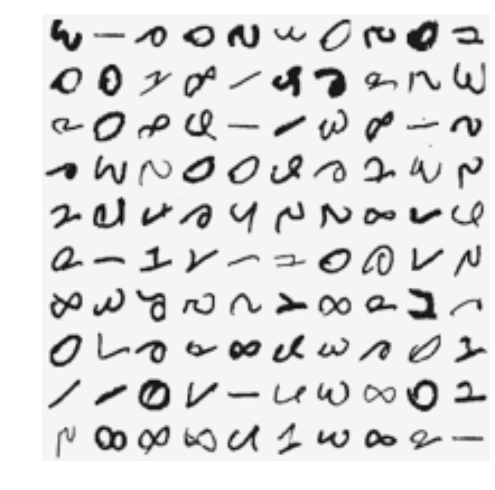

In [43]:
plt.imshow(image, cmap='Greys')
plt.axis('off')
plt.show()

### Part 2: Loading Pameters

In [44]:
params = scipy.io.loadmat('ex3weights.mat')
theta1 = params['Theta1']
theta2 = params['Theta2']
theta1.shape, theta2.shape

((25, 401), (10, 26))

### Part 3: Implement Predict

After training the neural network, we would like to use it to predict the labels. You will now implement the "predict" function to use the neural network to predict the labels of the training set. This lets you compute the training set accuracy.

In [45]:
X = np.concatenate((np.ones((m,1)), X_orig), axis=1)
X.shape, y_true.shape

((5000, 401), (5000, 1))

In [46]:
theta1.shape, theta1.T.shape, X.shape

((25, 401), (401, 25), (5000, 401))

In [49]:
a1 = h(theta1,X)
a1.shape

(5000, 25)